# Sheet 08

In [19]:
import pandas as pd
import numpy as np
from stop_words import get_stop_words
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from nltk.stem.snowball import SnowballStemmer

## Exercise 1: Multi-label classification

In [20]:
df = pd.read_csv('../data/JanataHack.csv', index_col='ID')
df

,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
ID,,,,,,,,
1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...
20968,Contemporary machine learning: a guide for pra...,Machine learning is finding increasingly bro...,1,1,0,0,0,0
20969,Uniform diamond coatings on WC-Co hard alloy c...,Polycrystalline diamond coatings have been g...,0,1,0,0,0,0
20970,Analysing Soccer Games with Clustering and Con...,We present a new approach for identifying si...,1,0,0,0,0,0


In [21]:
df.rename(columns={"TITLE": "title", "ABSTRACT" : "abstract"}, inplace=True)

In [22]:
# labels for the categories
categories = ["Computer Science", "Physics", "Mathematics", "Statistics", "Quantitative Biology", "Quantitative Finance"]

In [23]:
def add_category_as_single_column(df):
    df['category'] = df[categories[0]].astype(str) + df[categories[1]].astype(str) + df[categories[2]].astype(str) + df[categories[3]].astype(str) + df[categories[4]].astype(str) + df[categories[5]].astype(str)
    return df

In [24]:
df = add_category_as_single_column(df)
df

,title,abstract,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,category
ID,,,,,,,,,
1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0,100000
2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0,100000
3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0,001000
4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0,001000
5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0,100100
...,...,...,...,...,...,...,...,...,...
20968,Contemporary machine learning: a guide for pra...,Machine learning is finding increasingly bro...,1,1,0,0,0,0,110000
20969,Uniform diamond coatings on WC-Co hard alloy c...,Polycrystalline diamond coatings have been g...,0,1,0,0,0,0,010000
20970,Analysing Soccer Games with Clustering and Con...,We present a new approach for identifying si...,1,0,0,0,0,0,100000


In [25]:
labels = df['category'].unique()
print(labels)
print(f'Length of unique categories: {len(labels)}')

['100000' '001000' '100100' '010000' '000010' '000100' '011000' '001100'
 '101000' '000001' '110000' '101100' '010100' '110100' '100010' '000110'
 '000101' '011100' '100001' '000011' '100110' '111000' '100101' '001101']
Length of unique categories: 24


<AxesSubplot: >

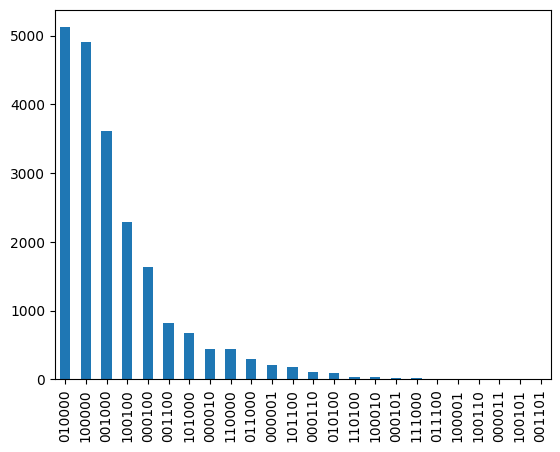

In [37]:
df.category.value_counts().plot(kind="bar")

When plotting all different classes including multi class labels, we can see that the dataset is **very** unbalanced.

First we need to do some cleaning.

In [26]:
#STOPWORDS = set(get_stop_words('english'))

def text_cleaning(text):
    # transform to lowercase for later use of 'stopwords'
    text = text.lower()
    
    # remove numbers
    text = re.sub(r'\w*\d+\w*', '', text)

    # remove formulas
    text = re.sub(r'\$[^$$]*\$', '', text)

    # remove stop words
    #text = ' '.join([word for word in text.split(' ') if word not in STOPWORDS])

    # remove symbols
    text = re.compile('[/(){}\[\]\|@,;~]').sub(' ', text)

    # replace over spaces
    text = re.sub('\s{2,}', " ", text)

    return text

In [27]:
df['abstract_cleaned'] = df['abstract'].apply(text_cleaning)

In [28]:
def stem_wrapper(word):
    stemmer = SnowballStemmer("english")
    return stemmer.stem(word)

## b) Apply Classification Algorithm

Prepare the train and test data for the classification algorithms.

In [29]:
X = df.abstract_cleaned
y = df.category

In [30]:
# prepare training and test data from dataframe
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Naives Bayes Classifier
description: https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes

In [31]:
pipe_nb = Pipeline([('vect', CountVectorizer(stop_words = "english",preprocessor=stem_wrapper)), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])
pipe_nb.fit(X_train, y_train)

y_pred = pipe_nb.predict(X_test)

/home/max/.local/share/virtualenvs/data_science-dDCtDHdq/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(


In [32]:
# evaluation
print(f'accuracy of naives bayes classifier {accuracy_score(y_pred, y_test)}')
print(classification_report(y_test, y_pred, zero_division = 0))

accuracy of naives bayes classifier 0.601907032181168
              precision    recall  f1-score   support

      000001       0.00      0.00      0.00        37
      000010       0.00      0.00      0.00        87
      000011       0.00      0.00      0.00         2
      000100       0.00      0.00      0.00       331
      000101       0.00      0.00      0.00         2
      000110       0.00      0.00      0.00        23
      001000       0.83      0.85      0.84       731
      001100       0.00      0.00      0.00       172
      010000       0.84      0.93      0.88      1044
      010100       0.00      0.00      0.00        16
      011000       0.00      0.00      0.00        62
      011100       0.00      0.00      0.00         2
      100000       0.41      0.96      0.57       956
      100010       0.00      0.00      0.00         5
      100100       0.55      0.04      0.07       453
      100101       0.00      0.00      0.00         1
      100110       0.00    

### Linear Support Vector Machine
description: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier

In [33]:
pipe_svm = Pipeline([('vect', CountVectorizer(stop_words = "english", preprocessor=stem_wrapper)), ('tfidf', TfidfTransformer()), ('svc', SVC(kernel="linear", degree = 3))])
pipe_svm.fit(X_train, y_train)

y_pred = pipe_svm.predict(X_test)

/home/max/.local/share/virtualenvs/data_science-dDCtDHdq/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(


In [34]:
# evaluation
print(f'accuracy of linear SVM classifier {accuracy_score(y_pred, y_test)}')
print(classification_report(y_test, y_pred, zero_division = 0))

accuracy of linear SVM classifier 0.6924910607866508
              precision    recall  f1-score   support

      000001       0.62      0.54      0.58        37
      000010       0.50      0.37      0.42        87
      000011       0.00      0.00      0.00         2
      000100       0.37      0.29      0.33       331
      000101       0.00      0.00      0.00         2
      000110       0.00      0.00      0.00        23
      001000       0.81      0.89      0.85       731
      001100       0.65      0.59      0.62       172
      010000       0.87      0.93      0.90      1044
      010100       0.00      0.00      0.00        16
      011000       0.67      0.03      0.06        62
      011100       0.00      0.00      0.00         2
      100000       0.63      0.82      0.71       956
      100010       0.00      0.00      0.00         5
      100100       0.48      0.51      0.49       453
      100101       0.00      0.00      0.00         1
      100110       0.00     

### k Nearest Neighbor

In [35]:
pipe_rfc = Pipeline([('vect', CountVectorizer(stop_words = "english", preprocessor=stem_wrapper)), ('tfidf', TfidfTransformer()), ('clf', KNeighborsClassifier())])
pipe_rfc.fit(X_train, y_train)

y_pred = pipe_rfc.predict(X_test)

/home/max/.local/share/virtualenvs/data_science-dDCtDHdq/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(


In [36]:
# evaluation
print(f'accuracy of k nearest neighbour classifier {accuracy_score(y_pred, y_test)}')
print(classification_report(y_test, y_pred, zero_division = 0))

accuracy of k nearest neighbour classifier 0.6195470798569725
              precision    recall  f1-score   support

      000001       0.44      0.51      0.48        37
      000010       0.40      0.33      0.36        87
      000011       0.00      0.00      0.00         2
      000100       0.30      0.36      0.32       331
      000101       0.00      0.00      0.00         2
      000110       0.23      0.13      0.17        23
      001000       0.73      0.84      0.78       731
      001100       0.45      0.41      0.43       172
      010000       0.84      0.84      0.84      1044
      010100       0.33      0.06      0.11        16
      011000       0.44      0.06      0.11        62
      011100       0.00      0.00      0.00         2
      100000       0.60      0.71      0.65       956
      100010       0.00      0.00      0.00         5
      100100       0.42      0.38      0.40       453
      100101       0.00      0.00      0.00         1
      100110       

Our conclusion is that the **linear SVM** classifier performs best, with an accuracy of 0.69... For all three classifiers, when examining the confusion matrix, we see that the class *010000* performs best. This is coherent with the class inbalance plot we showed above, since this class contains the most data.